## Quora question pairs 

### Note: This notebook is for optimizing xgboost parameters

Find out if a pair of questions on Quora website are duplicated. 

In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from os import path
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import xgboost as xgb

### I. Data Exploration

In [2]:
#Read in training data
train_data_raw = pd.read_csv("train.csv")
train_data_raw.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


There are 37% duplicate questions in the training set. We also see that there are many identical questions in the data set. 

In [3]:
#Read in test data and look at the first 5 rows
test_data_raw = pd.read_csv("test.csv")
print "Number of testing data: %d" %len(test_data_raw)
test_data_raw.head(5)

Number of testing data: 2345796


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


Two word clouds generated from question 1 and question 2 show that there are a few duplicate most common words in them.

### II. Data Processing

First let's write some functions for calculating word share and TFIDF word share.

In [4]:
#Function to calculate normalized word share between two questions
def word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [5]:
#Combine all questions into corpus for TFIDF analysis
train_questions = pd.Series(train_data_raw['question1'].tolist() + train_data_raw['question2'].tolist()).astype(str)
test_questions = pd.Series(test_data_raw['question1'].tolist() + test_data_raw['question2'].tolist()).astype(str)
#Implement TFIDF function
def get_weight(count, eps=5000, min_count=2):
    if count < min_count:
        return 0 #remove words only appearing once 
    else:
        R = 1.0 / (count + eps)
        return R

eps = 5000 
words = (" ".join(train_questions)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
print "Most common words: ", (sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])

Most common words:  [('the', 2.623060902228028e-06), ('what', 3.164927538983995e-06), ('is', 3.651647440742891e-06), ('how', 4.463907079310237e-06), ('i', 4.5832664940302954e-06), ('a', 4.646127684881036e-06), ('to', 4.783155639101341e-06), ('in', 5.006909535158519e-06), ('of', 6.100834594172483e-06), ('do', 6.260956674179815e-06)]


In [6]:
#Calculate TFIDF word match share as our new feature
def tfidf_word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" "))) 
    if len(w1)==0 or len(w2)==0:
        return 0
    common = w1 & w2
    share_weight = [weights.get(word, 0) for word in common]
    total_weight = [weights.get(word, 0) for word in w1]+[weights.get(word, 0) for word in w2]
    return np.sum(share_weight)/np.sum(total_weight)

In [7]:
#Construct features for training data: character length, number of words, normalized word share 
train_data = pd.DataFrame(dtype='float64')
train_data['q1chrlen'] = train_data_raw['question1'].str.len()
train_data['q2chrlen'] = train_data_raw['question2'].str.len()
train_data['q1_nword'] = train_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
train_data['q2_nword'] = train_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
train_data['word_share'] = train_data_raw.apply(word_share_norm, axis=1)
train_data['TFIDF_share'] = train_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
train_data.head()

,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share,TFIDF_share
0,66,57.0,14,12,0.434783,0.400611
1,51,88.0,8,13,0.200000,0.193056
2,73,59.0,14,10,0.166667,0.149204
3,50,65.0,11,9,0.000000,0.000000
4,76,39.0,13,7,0.100000,0.009949


In [8]:
#Check if there's NaN values in the data. If yes, replace them.
np.sum(np.isnan(train_data))
train_data.loc[:,'q2chrlen'] = np.nan_to_num(train_data.loc[:,'q2chrlen'])
np.sum(np.isnan(train_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

In [9]:
#Process test data to have the same features as training data
test_data = pd.DataFrame()
test_data['q1chrlen'] = test_data_raw['question1'].str.len()
test_data['q2chrlen'] = test_data_raw['question2'].str.len()
test_data['q1_nword'] = test_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
test_data['q2_nword'] = test_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
test_data['word_share'] = test_data_raw.apply(word_share_norm, axis=1)
test_data['TFIDF_share'] = test_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
#Replace NaN if any
np.sum(np.isnan(test_data))
test_data.loc[:,['q1chrlen','q2chrlen']] = np.nan_to_num(test_data.loc[:,['q1chrlen','q2chrlen']])
np.sum(np.isnan(test_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

### III. Feature Visualization and Normalization

In [10]:
#Normalized feature values
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

In [18]:
#shuffle data
from sklearn.utils import shuffle
train_data = shuffle(train_data, random_state = 100)

In [19]:
#Split training data to train and validation data sets
label = train_data_raw['is_duplicate']
X_train, X_valid, y_train, y_valid = train_test_split(train_data, label, test_size=0.2, random_state=10)
X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(train_data_scaled, label, test_size=0.2, random_state=10)

### IV. Benchmark Model

We use Random Forest as my benchmark model here. Later on I'll try to beat the benchmark accuracy.

In [13]:
#Benchmark model : random forest
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train_scaled,y_train)
prediction = rfc.predict_proba(X_valid_scaled)
pre = rfc.predict(X_valid_scaled)
score_rfc = rfc.score(X_valid_scaled, y_valid)
print "Random Forest (Benchmark model) has accuracy: %.3f" %score_rfc

Random Forest (Benchmark model) has accuracy: 0.721


In [14]:
#Test submission for Kaggle competition
prediction = rfc.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('rfc_submission.csv', index=False)

Kaggle leaderboard score : 0.55

### V. Optimize XGboost model

In [21]:
#Model 6: XGBoost 
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.3
params['max_depth'] = 4
params['subsample'] = 0.5
params['gamma'] = 20
params['colsample_bytree'] = 0.5
params['min_child_weight'] = 10

d_train = xgb.DMatrix(X_train_scaled, label=y_train)
d_valid = xgb.DMatrix(X_valid_scaled, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)
d_test = xgb.DMatrix(test_data_scaled)
p_test = bst.predict(d_test)

[0]	train-logloss:0.615724	valid-logloss:0.61545
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.483744	valid-logloss:0.483632
[20]	train-logloss:0.470675	valid-logloss:0.470967
[30]	train-logloss:0.466604	valid-logloss:0.467019
[40]	train-logloss:0.464784	valid-logloss:0.465407
[50]	train-logloss:0.463315	valid-logloss:0.464068
[60]	train-logloss:0.462051	valid-logloss:0.462844
[70]	train-logloss:0.461539	valid-logloss:0.462333
[80]	train-logloss:0.460284	valid-logloss:0.461159
[90]	train-logloss:0.459756	valid-logloss:0.460707
[100]	train-logloss:0.459093	valid-logloss:0.460169
[110]	train-logloss:0.458911	valid-logloss:0.460039
[120]	train-logloss:0.458597	valid-logloss:0.459738
[130]	train-logloss:0.458447	valid-logloss:0.459557
[140]	train-logloss:0.458393	valid-logloss:0.459488
[150]	train-logloss:0.458142	valid-logloss:0.45926
[160]	train-logloss:0.457921	v

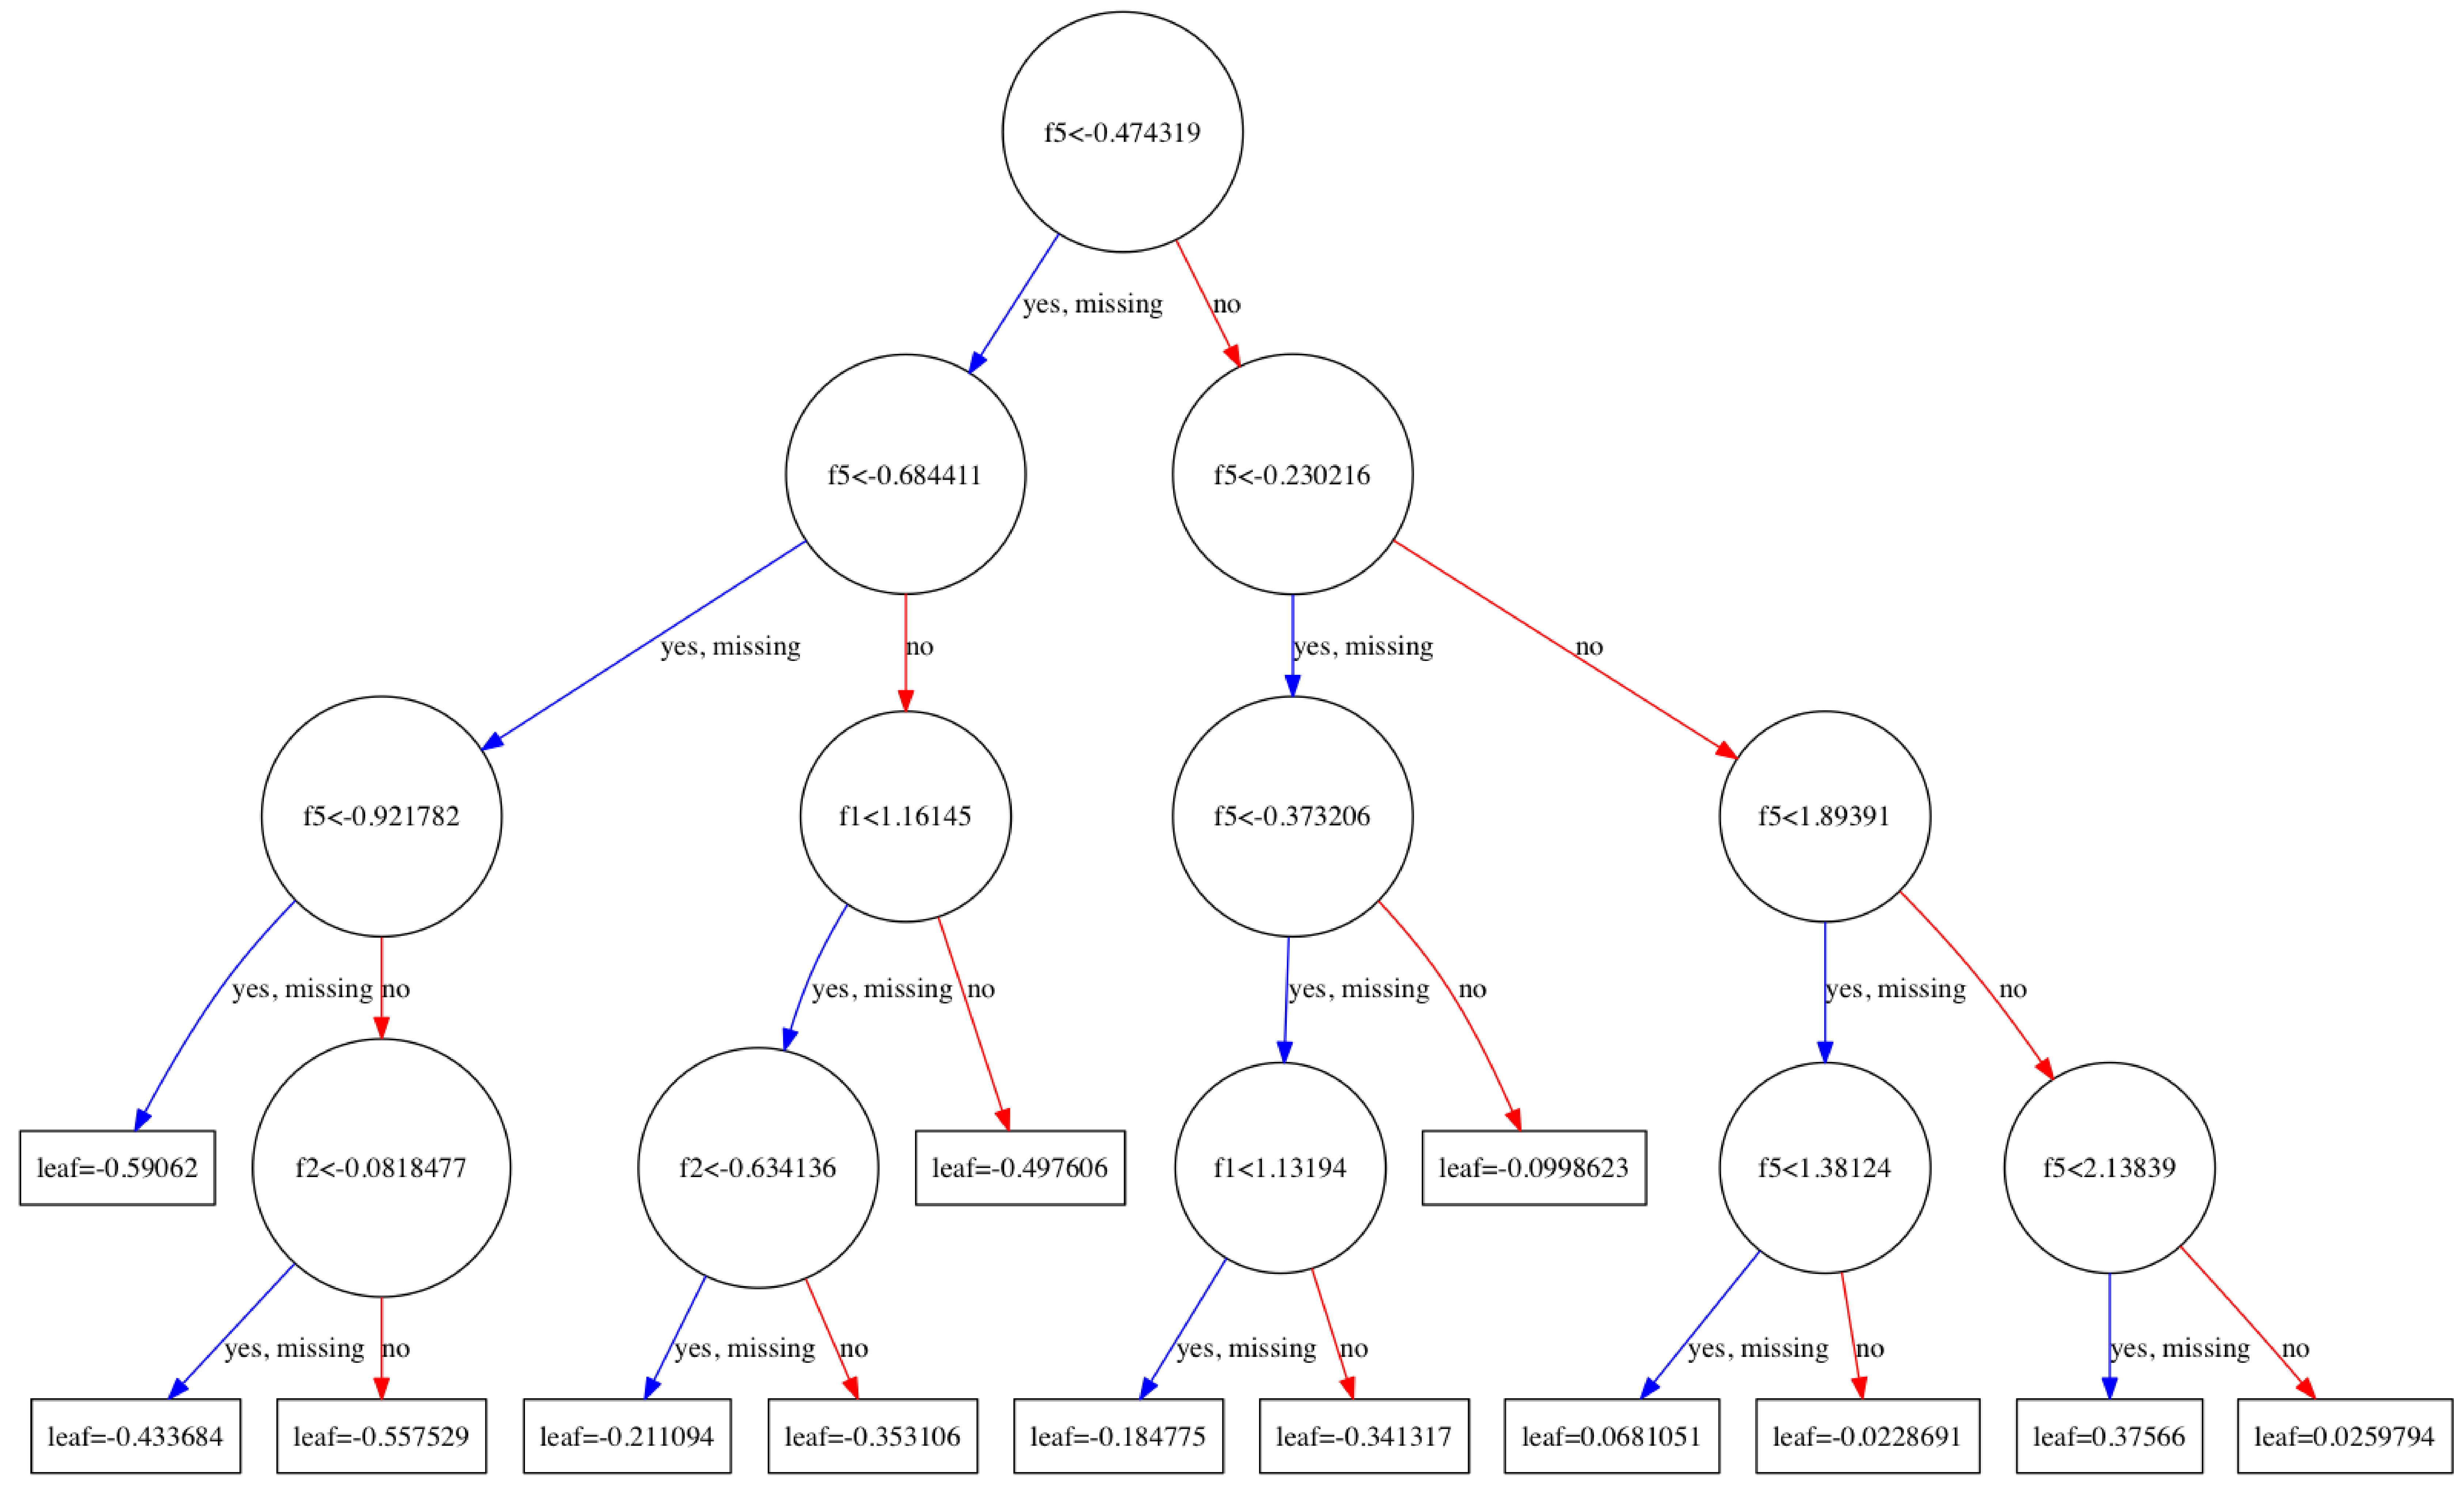

In [22]:
#Visualize the prediction
from matplotlib.pylab import rcParams
from xgboost import plot_tree
rcParams['figure.figsize'] = 120,100
plot_tree(bst)